In [1]:
import numpy as np
import scipy.signal as signal
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

#### Fast Spectral Correlation (https://es.mathworks.com/matlabcentral/fileexchange/60561-fast_sc-x-nw-alpha_max-fs-opt) in Python

##### Function definitions:

In [2]:
def param_fast_sc(L, Nw, alpha_max, Fs):
    """
    Computes the number of overlapped samples Nv to be used in the Fast STFT-based
    estimator of the Spectral Correlation given a signal length L, a window length Nw, 
    the maximum cyclic frequency alpha_max, and the sampling frequency Fs.
    
    Outputs:
        Nv: Number of overlapped samples
        dt: Time resolution of STFT (in seconds)
        da: Cyclic frequency resolution (in Hz)
        df: Carrier frequency resolution (in Hz)
    """
    R = max(1, min(int(Fs / (2 * alpha_max)), int(0.25 * Nw))) # block shift
    Nv = Nw - R # block overlap
    dt = R / Fs # time resolution of STFT (in s)
    da = Fs / L # Cyclic frequency resolution (in Hz)
    df = Fs / Nw  # Spectral frequency resolution (in Hz) || Revisar caso Nw sea un vector-> df = Fs/Nw*sum(Nw.^2)/mean(Nw)^2

    return Nv, dt, da, df

def cps_stft_zoom(alpha0, STFT, Dt, Window, Fs=1, Nfft=None):
    """
    Fast estimation of the zoomed Spectral Correlation from the Short-Time-Fourier-Transform.
    
    Inputs:
    -------
    alpha0: zoomed cyclic frequency (in Hz).
    STFT: Short-Time-Fourier-Transform matrix (positive frequencies)x(times) as obtained from a standard algorithm
    (if STFT has 3 dimensions, the cross-spectral correlation is computed between STFT(:,:,1) and STFT(:,:,2)).
    Dt: sampling period (in seconds) of the STFT.
    Window: window used in STFT.
    Fs: sampling frequency in Hz (default = 1Hz).
    Nfft: number of FFT bins used for cyclic frequencies (should be greater than size(STFT,2)).
    
    Outputs:
    --------
    S: zoomed Spectral Correlation matrix ; dimension = (positive frequencies)x(cyclic frequencies).
    alpha: vector of cyclic frequencies in Hz.
    alpha0: actual zoomed cyclic frequency in Hz (may be different from input value due to round-off to an integer number of frequency bins).
    fk: frequency bin number corresponding to alpha0.
    Fa: cyclic sampling frequency (in Hz) (Fa/2 = maximum cyclic frequency).
    """
    NF, NT = STFT.shape # || podría tener más dimensiones
    Nw = 2 * (NF - 1) # || window length
    Fa = 1 / Dt  # || cyclic sampling frequency in Hz
    
    if Nfft is None:
        Nfft = NT
    elif Nfft < NT:
        raise ValueError('Nfft must be greater than or equal to the number of time samples in STFT!')
    
    if abs(alpha0) > Fa / 2:
        print(f'|alpha0| must be selected smaller than {Fa/2}!!')

    alpha = Fa * np.arange(Nfft) / Nfft  # || Vector of cyclic frequencies

    fk = int(round(alpha0 / Fs * Nw))
    alpha0 = fk / Nw * Fs

    if fk >= 0:
        S = np.vstack([STFT[fk:NF, :], np.zeros((fk, NT))]) * np.conj(STFT)
    else:
        S = np.vstack([np.conj(STFT[-fk:NF, :]), np.zeros((-fk, NT))]) * STFT

    S = fft(S, Nfft, axis=1) / NT
     # Calibration
    S = S / np.sum(Window ** 2) / Fs
     # Removal of aliased cyclic frequencies
    ak = int(round(alpha0 / Fa * Nfft))
    S[:, int(Nfft / 2) + 1 + ak:Nfft] = 0

    # Phase correction
    Iw = np.argmax(Window) 
    S = S * np.exp(-2j * np.pi * Iw * (alpha - alpha0) / Fs)

    return S, alpha, alpha0,fk,Fa

def window_stft_zoom(alpha, alpha0, Dt, Window, Nfft, Fs, opt='full'):
    """
    Returns the spectral "zooming window" of the STFT-based zoom algorithm.
    
    Inputs:
    -------
    alpha: vector of cyclic frequencies in Hz.
    alpha0: zoomed cyclic frequency in Hz.
    Dt: sampling period (in seconds) of the STFT.
    Window: window used in STFT.
    Fs: sampling frequency in Hz (default = 1Hz).
    Nfft: number of points in FFT.
    opt: the full window is returned ('full') or its truncated version ('trunc') without aliasing.
    """
    Fa = 1 / Dt
    WSquared = Window ** 2
    Iw = np.argmax(Window)
    W1 = np.zeros(Nfft)
    W2 = np.zeros(Nfft)
    n = np.arange(0, Iw) / Fs

    for k in range(Nfft):
        W1[k] = WSquared[Iw] + 2 * np.sum(WSquared[Iw - 1::-1] * np.cos(2 * np.pi * n * (alpha[k] - alpha0)))
        W2[k] = WSquared[Iw] + 2 * np.sum(WSquared[Iw - 1::-1] * np.cos(2 * np.pi * n * (alpha[k] - alpha0 - Fa)))

    W = W1 + W2

    if opt == 'trunc':
        ak = int(round(alpha0 / Fa * Nfft))
        W[int(Nfft / 2) + 1 + ak:Nfft] = 0

    return W, W1, W2

def shift_window_stft_zoom(W0, a0, opt):
    #Circular shift of window W0 by a0 (possibly non-integer) samples.
    Nfft = len(W0)
    a1 = int(np.floor(a0))
    a2 = int(np.ceil(a0))

    if a1 == a2:
        W = np.roll(W0, int(a0))
    else:
        W = np.roll(W0, a1) * (1 - (a0 - a1)) + np.roll(W0, a2) * (a0 - a1)

    if opt == 'trunc':
        W[int(Nfft / 2) + 1 + int(round(a0)):Nfft] = 0

    return W

def lite_spectrogram(x, Window, Noverlap, Nfft, Fs=1):
    # Computation of the STFT of signal x.
    if isinstance(Window, int):
        Window = np.hanning(Window)
    Window = Window.flatten() 
    L = len(x)
    Nw = len(Window)
    R = Nw - Noverlap

    x = x.flatten() 
    K = int((L - Noverlap) / R) # Number of windows

    X = np.zeros((int(Nfft / 2) + 1, K), dtype=complex)
    index = np.array([0, Nw])

    for k in range(K):
        Xw = fft(Window * x[index[0]:index[1]], Nfft)
        X[:, k] = Xw[:int(Nfft / 2) + 1]
        index = index+R

    #f = np.arange(0, Nfft / 2 + 1) / Nfft * Fs
    f = np.linspace(0,Fs/2,int(Nfft / 2 + 1))
    t = (Nw / 2 + np.arange(0, K * R, R)) / Fs

    return X, f, t

def fast_sc_stft(STFT, Dt, Window, Fs=1, Nfft=None, opt=None):
    """
    Fast estimation of the Spectral Correlation by scanning several zooms obtained from the short-time-Fourier-transform.
    
    Inputs:
    -------
    STFT: Short-Time-Fourier-Transform matrix ; dimension = (positive frequencies)x(time instants)
    
    Dt: sampling period (in seconds) of the STFT.
    Window: window used in STFT.
    Fs: sampling frequency in Hz (default = 1Hz).
    Nfft: number of FFT bins used for cyclic frequencies (should be greater than size(STFT,2)).
    opt.abs = 0 or 1: summation of the complex values (default) or absolute magnitudes of the scans.
    opt.calib = 1 or 0: S is equalized by the spectral "scanning" window (default) or not.
    opt.coh = 1: the spectral COHERENCE is computed instead of the (default) spectral CORRELATION.
    
    Outputs:
    --------
    S: "scanned" spectral correlation matrix ; dimension = (positive frequencies)x(cyclic frequencies).
    alpha: vector of cyclic frequencies in Hz.
    W: spectral "scanning window".
    """
    NF, NT = STFT.shape  #### (if STFT has 3 dimensions, the CROSS-spectral correlation is computed between STFT(:,:,1) and STFT(:,:,2))
    Nw = 2 * (NF - 1)

    if Nfft is None:
        Nfft = NT

    if opt is None:
        opt = {'abs': 0, 'calib': 1, 'coh': 0}

    if isinstance(Window, int):
        Window = np.hanning(Window)

    if opt['coh'] == 1:
        Sx = np.mean(np.abs(STFT) ** 2, axis=1)
        STFT = STFT * (1.0 / np.sqrt(Sx[:, np.newaxis]))

    S, alpha, _alpha0,_fk,_Fa = cps_stft_zoom(0, STFT, Dt, Window, Fs, Nfft)
    W0,_W10,_W20 = window_stft_zoom(alpha, 0, Dt, Window, Nfft, Fs, 'full')

    if opt['abs'] == 1:
        S = np.abs(S)
        W = np.abs(W0)
    else:
        W = W0

    W[int(Nfft / 2) + 1:Nfft] = 0

    Fa = 1 / Dt
    K = int(Nw / 2 * Fa / Fs) # Number of scans

    for k in range(1, K + 1):
        Stemp, alpha, alpha0, _fk,_Fa = cps_stft_zoom(k / Nw * Fs, STFT, Dt, Window, Fs, Nfft)
        Wtemp = shift_window_stft_zoom(W0, alpha0 / Fa * Nfft, 'trunc')
        if opt['abs'] == 1:
            S[:, 1:Nfft] += np.abs(Stemp[:, 1:Nfft])
            W[1:Nfft] += np.abs(Wtemp[1:Nfft])
        else:
            S[:, 1:Nfft] += Stemp[:, 1:Nfft]
            W[1:Nfft] += Wtemp[1:Nfft]

        Stemp, alpha, alpha0,_fk,_Fa = cps_stft_zoom(-k / Nw * Fs, STFT, Dt, Window, Fs, Nfft)
        Wtemp = shift_window_stft_zoom(W0, alpha0 / Fa * Nfft, 'trunc')
        if opt['abs'] == 1:
            S[:, 1:Nfft] += np.abs(Stemp[:, 1:Nfft])
            W[1:Nfft] += np.abs(Wtemp[1:Nfft])
        else:
            S[:, 1:Nfft] += Stemp[:, 1:Nfft]
            W[1:Nfft] += Wtemp[1:Nfft]

    if opt['calib'] == 1:
        Winv = np.ones(Nfft)
        I = np.where(W < 0.5 * W[0])
        Winv[:I[0][0]] = 1.0 / W[:I[0][0]]
        Winv[I[0][0] + 1:Nfft] = 1.0 / W[I[0][0] + 1]
        S = S * Winv * np.sum(Window ** 2)
    else:
        Winv = 1.0 / W[0]
        S = S * Winv * np.sum(Window ** 2)

    if opt['coh'] == 1:
        S = S / np.mean(S[:, 0])

    return S, alpha, W, Winv

In [3]:
def fast_sc(x, Nw, alpha_max, Fs=1, opt=None):
    if alpha_max > Fs / 2:
        raise ValueError("'alpha_max' must be smaller than Fs/2!")
    if alpha_max < 0:
        raise ValueError("'alpha_max' must be non-negative!")

    if opt is None:
        opt = {'coh': 0}

    Nv, dt,_da,_df = param_fast_sc(len(x), Nw, alpha_max, Fs)
    STFT, f, t = lite_spectrogram(x, Nw, Nv, Nw, Fs)
    S, alpha, _W, _Winv = fast_sc_stft(STFT, dt, Nw, Fs, opt=opt)

    I = np.where(alpha <= alpha_max)
    alpha = alpha[I]
    S = S[:, I]

    return S, alpha, f, STFT, t, Nv

##### Demo I

In [4]:
Fs = 1e3  
L = int(1e5)  
f0 = 0.01 * Fs

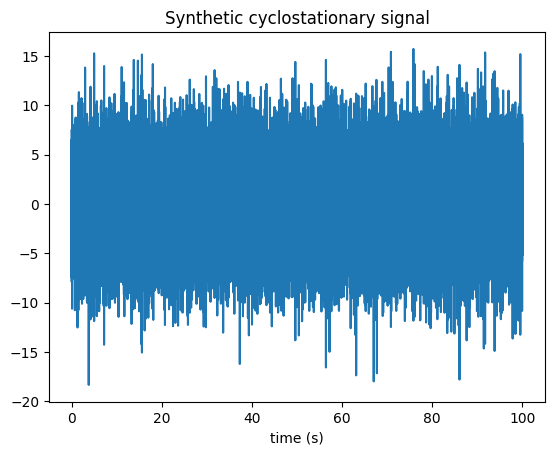

In [5]:
x = np.random.randn(L)

a = [1, -2 * np.cos(2 * np.pi * 0.2) * 0.9, 0.9 ** 2]
x = signal.lfilter([1], a, x)

x = x * (1 + np.sin(2 * np.pi * np.arange(L) * f0 / Fs))

x = x + np.std(x) * np.random.randn(L)

plt.figure()
plt.plot(np.arange(L) / Fs, x)
plt.title('Synthetic cyclostationary signal')
plt.xlabel('time (s)')
plt.show()

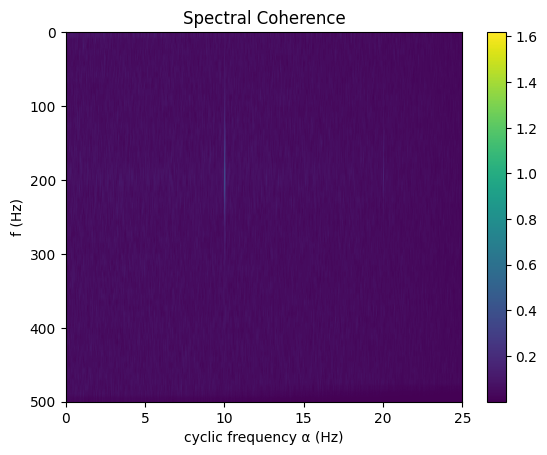

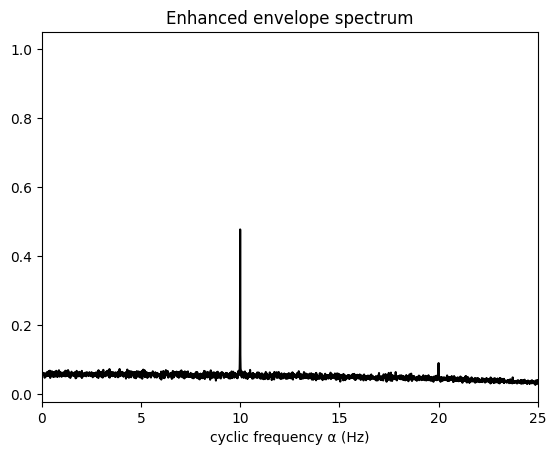

In [6]:
Nw = 2 ** 7 
#alpha_max = 4 * f0
alpha_max=25
opt = {'abs': 0,'coh': 1,'calib': 0}  
S, alpha, f, _STFT, _t, Nv = fast_sc(x, Nw, alpha_max, Fs, opt)

S = np.squeeze(S, axis=1)

plt.figure()
#plt.subplot(211)
plt.imshow(np.abs(S), aspect='auto', extent=[alpha[1], alpha[-1], f[-1], f[0]], origin='upper')
plt.colorbar()
plt.title('Spectral Coherence' if opt['coh'] else 'Spectral Correlation')
plt.xlabel('cyclic frequency α (Hz)')
plt.ylabel('f (Hz)')
plt.xlim([0, alpha_max])
plt.show()

plt.figure()
#plt.subplot(212)
plt.plot(alpha, np.mean(np.abs(S), axis=0), 'k')
plt.xlim([0, alpha_max])
plt.title('Enhanced envelope spectrum')
plt.xlabel('cyclic frequency α (Hz)')
plt.show()

##### Demo II: Fault bearing signal with constant rotational speed

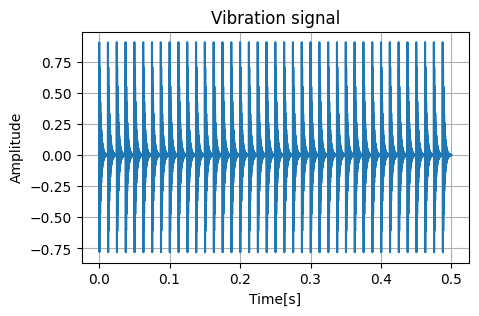

In [7]:
Ar= 1   #Amplitude
f = 2000    #Resonant Frequency in Hz
b=500       #Exponential decay factor
α=4      #Fault characteristic coeficient
fs=1e4  #Freq. Sampling

N=5000
n=np.arange(N)
t=n/fs

#fr_var=curve_rayleigh(t)
#fr_var=np.linspace(20,80,N)
fr_var=20*np.ones((N,))
f_fail=α*fr_var
ω_fail=2*np.pi*f_fail
θr_fail=np.cumsum(ω_fail)/fs

t_indexes=[]
t_impact=[]
N_of_impacts=np.int32(np.floor(np.max(θr_fail)/(2*np.pi)))+1
for i in range(N_of_impacts):
    t_index=np.argmin(np.abs(θr_fail-i*2*np.pi))
    t_indexes.append(t_index)
    t_impact.append(t[t_index])
    #print(i,t_index,t[t_index])

impacts=(np.array(t_indexes),np.array(t_impact))

Sx_var=np.zeros((N,))

for r in range(len(t_impact)):
    Sx_var+=Ar*np.sin(2*np.pi*f*(n/fs-t_impact[r]))*np.exp(-b*(n/fs-t_impact[r]))*np.heaviside(n/fs-t_impact[r], 1)

%matplotlib inline
plt.figure(figsize=(5,3))
plt.plot(t,Sx_var)
plt.grid(True)
plt.title('Vibration signal')
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
#plt.savefig('Sx.pdf',bbox_inches='tight')
plt.show()

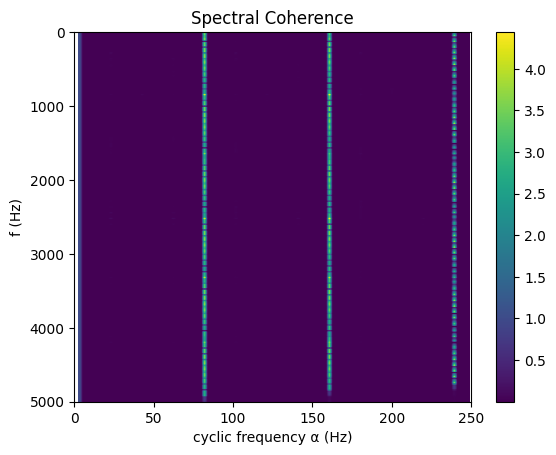

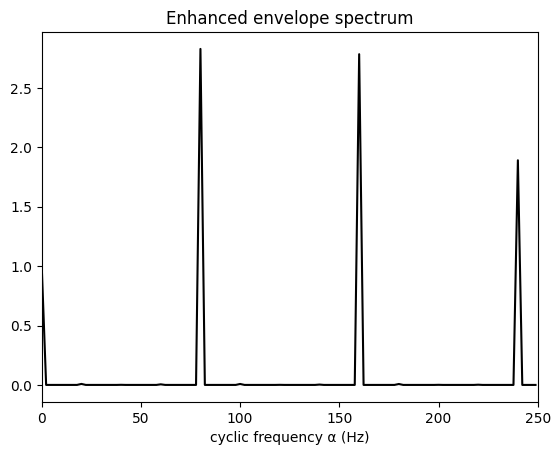

In [25]:
Nw = 2 ** 9
alpha_max=250
opt = {'abs': 0,'coh': 1,'calib': 0}  

S, alpha, f, _STFT, _t, Nv = fast_sc(Sx_var, Nw, alpha_max, fs, opt)
S = np.squeeze(S, axis=1)

plt.figure()
#plt.subplot(211)
plt.imshow(np.abs(S), aspect='auto', extent=[alpha[1], alpha[-1], f[-1], f[0]], origin='upper')
plt.colorbar()
plt.title('Spectral Coherence' if opt['coh'] else 'Spectral Correlation')
plt.xlabel('cyclic frequency α (Hz)')
plt.ylabel('f (Hz)')
plt.xlim([0, alpha_max])
plt.show()

plt.figure()
#plt.subplot(212)
plt.plot(alpha, np.mean(np.abs(S), axis=0), 'k')
plt.xlim([0, alpha_max])
plt.title('Enhanced envelope spectrum')
plt.xlabel('cyclic frequency α (Hz)')
plt.show()

##### Demo III: Fault bearing signal with some variation in the rotational speed

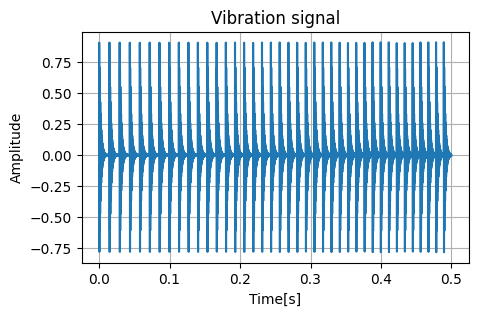

In [8]:
Ar= 1   #Amplitude
f = 2000    #Resonant Frequency in Hz
b=500       #Exponential decay factor
α=4      #Fault characteristic coeficient
fs=1e4  #Freq. Sampling

N=5000
n=np.arange(N)
t=n/fs

dev=3
fr_var=np.linspace(20-dev,20+dev,N)
f_fail=α*fr_var
ω_fail=2*np.pi*f_fail
θr_fail=np.cumsum(ω_fail)/fs

t_indexes=[]
t_impact=[]
N_of_impacts=np.int32(np.floor(np.max(θr_fail)/(2*np.pi)))+1
for i in range(N_of_impacts):
    t_index=np.argmin(np.abs(θr_fail-i*2*np.pi))
    t_indexes.append(t_index)
    t_impact.append(t[t_index])
    #print(i,t_index,t[t_index])

impacts=(np.array(t_indexes),np.array(t_impact))

Sx_var=np.zeros((N,))

for r in range(len(t_impact)):
    Sx_var+=Ar*np.sin(2*np.pi*f*(n/fs-t_impact[r]))*np.exp(-b*(n/fs-t_impact[r]))*np.heaviside(n/fs-t_impact[r], 1)

%matplotlib inline
plt.figure(figsize=(5,3))
plt.plot(t,Sx_var)
plt.grid(True)
plt.title('Vibration signal')
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
#plt.savefig('Sx.pdf',bbox_inches='tight')
plt.show()

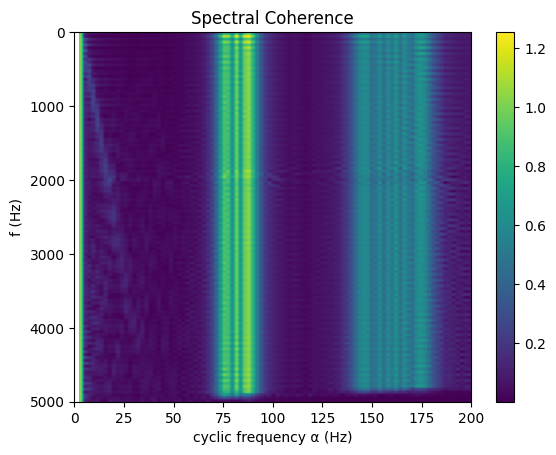

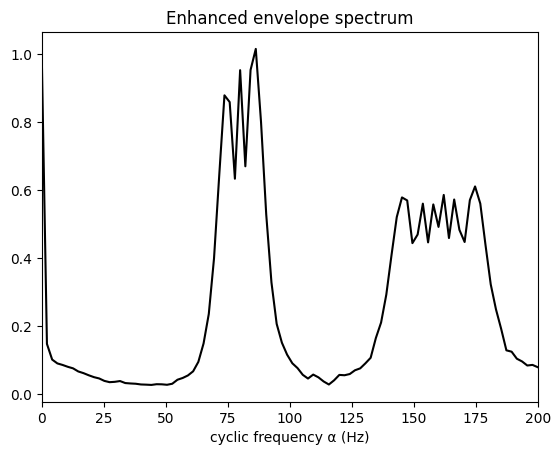

In [294]:
Nw = 2 ** 8
alpha_max=200
opt = {'abs': 0,'coh': 1,'calib': 0}  

S, alpha, f, _STFT, _t, Nv = fast_sc(Sx_var, Nw, alpha_max, fs, opt)
S = np.squeeze(S, axis=1)

plt.figure()
#plt.subplot(211)
plt.imshow(np.abs(S), aspect='auto', extent=[alpha[1], alpha[-1], f[-1], f[0]], origin='upper')
plt.colorbar()
plt.title('Spectral Coherence' if opt['coh'] else 'Spectral Correlation')
plt.xlabel('cyclic frequency α (Hz)')
plt.ylabel('f (Hz)')
plt.xlim([0, alpha_max])
plt.show()

plt.figure()
#plt.subplot(212)
plt.plot(alpha, np.mean(np.abs(S), axis=0), 'k')
plt.xlim([0, alpha_max])
plt.title('Enhanced envelope spectrum')
plt.xlabel('cyclic frequency α (Hz)')
plt.show()

#### Demo IV: The input signal is the sum of two monocomponent signals

Notice in the plots that peaks appear at fm1-fm2 y en fm1+fm2 in the plots of the signal after summation, which don't appear in the plots of the individual amplitude-modulated signals.

5000


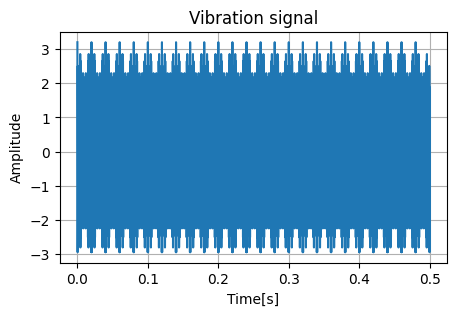

In [44]:
###Introducing other signal for non-linealinearity
fc1=1500
fc2=1500
fm1=250
fm2=200

Sx1=(1+0.7*np.cos(2*np.pi*fm1*n/fs))*np.cos(2*np.pi*fc1*n/fs)
Sx2=(1+0.5*np.cos(2*np.pi*fm2*n/fs))*np.cos(2*np.pi*fc2*n/fs)
Sx=Sx1+Sx2

print(len(n))
plt.figure(figsize=(5,3))
plt.plot(t,Sx)
plt.grid(True)
plt.title('Vibration signal')
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
#plt.savefig('Sx.pdf',bbox_inches='tight')
plt.show()

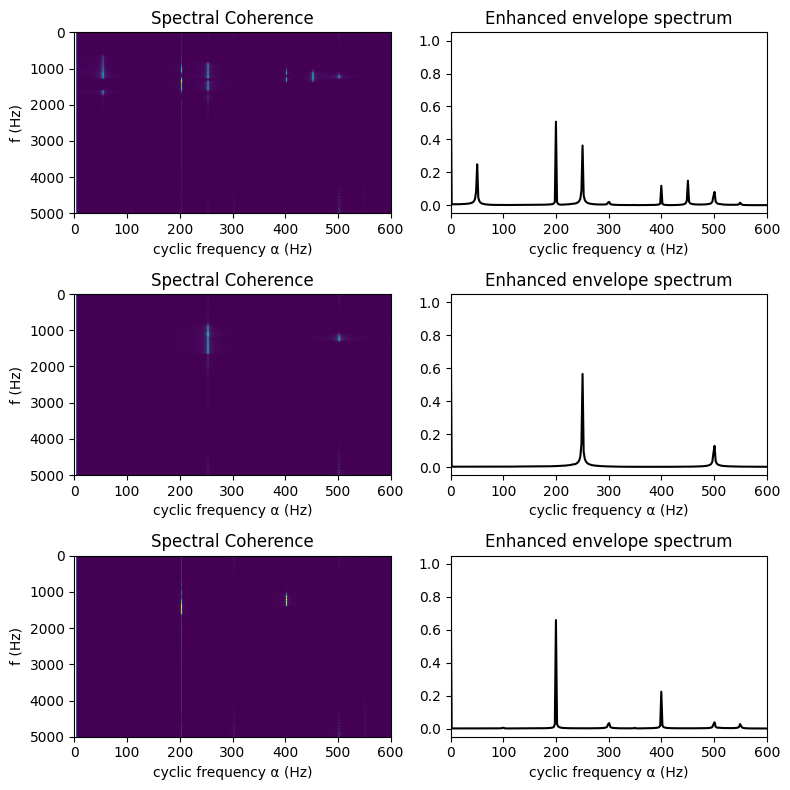

In [46]:
Nw = 2 ** 8
alpha_max=600
opt = {'abs': 0,'coh': 1,'calib': 0}  

S_sum, alpha, f, _STFT, _t, Nv = fast_sc(Sx, Nw, alpha_max, fs, opt)
S_sum = np.squeeze(S_sum, axis=1)

S_1, alpha, f, _STFT, _t, Nv = fast_sc(Sx1, Nw, alpha_max, fs, opt)
S_1 = np.squeeze(S_1, axis=1)
S_2, alpha, f, _STFT, _t, Nv = fast_sc(Sx2, Nw, alpha_max, fs, opt)
S_2 = np.squeeze(S_2, axis=1)

fig, ax = plt.subplots(3, 2, figsize=(8, 8))

ax[0,0].imshow(np.abs(S_sum), aspect='auto', extent=[alpha[1], alpha[-1], f[-1], f[0]], origin='upper')
#ax[0,0].colorbar()
ax[0,0].set_title('Spectral Coherence' if opt['coh'] else 'Spectral Correlation')
ax[0,0].set_xlabel('cyclic frequency α (Hz)')
ax[0,0].set_ylabel('f (Hz)')
ax[0,0].set_xlim([0, alpha_max])



ax[0,1].plot(alpha, np.mean(np.abs(S_sum), axis=0), 'k')
ax[0,1].set_xlim([0, alpha_max])
ax[0,1].set_title('Enhanced envelope spectrum')
ax[0,1].set_xlabel('cyclic frequency α (Hz)')


ax[1,0].imshow(np.abs(S_1), aspect='auto', extent=[alpha[1], alpha[-1], f[-1], f[0]], origin='upper')
#ax[1,0].colorbar()
ax[1,0].set_title('Spectral Coherence' if opt['coh'] else 'Spectral Correlation')
ax[1,0].set_xlabel('cyclic frequency α (Hz)')
ax[1,0].set_ylabel('f (Hz)')
ax[1,0].set_xlim([0, alpha_max])

ax[1,1].plot(alpha, np.mean(np.abs(S_1), axis=0), 'k')
ax[1,1].set_xlim([0, alpha_max])
ax[1,1].set_title('Enhanced envelope spectrum')
ax[1,1].set_xlabel('cyclic frequency α (Hz)')

ax[2,0].imshow(np.abs(S_2), aspect='auto', extent=[alpha[1], alpha[-1], f[-1], f[0]], origin='upper')
#ax[1,0].colorbar()
ax[2,0].set_title('Spectral Coherence' if opt['coh'] else 'Spectral Correlation')
ax[2,0].set_xlabel('cyclic frequency α (Hz)')
ax[2,0].set_ylabel('f (Hz)')
ax[2,0].set_xlim([0, alpha_max])

ax[2,1].plot(alpha, np.mean(np.abs(S_2), axis=0), 'k')
ax[2,1].set_xlim([0, alpha_max])
ax[2,1].set_title('Enhanced envelope spectrum')
ax[2,1].set_xlabel('cyclic frequency α (Hz)')

plt.tight_layout()
plt.show()